# Getting ready for manual annotation on MIMIC-CXR dataset

There are 227835 reports in the dataset, each report has multiple section, such as findings and imporession.

Usage:

To get the first 100 ann docs (round 1): we sample based on the token numbers and the number of coreference groups per doc, where the statistics are based on the majority voting of scoref, dcoref and fast-coref-joint

1. Run Prepare 1 to get ready
2. Run all scripts in the "Analyse" section
3. Run step 1 to get 100 docs for round 1 manual annotation

To get the data for assessing the efficiency of pure manual annotaion and semi-auto annotation.

1. Run Prepare 1, "Analyse", and Prepare 2 to get ready
2. Opt1: run Step 2 to get 100 docs without .ann files for round 2 - manual annotation data
3. Opt2: run Step 3 to get 100 docs with .ann files for round 3 - semi-auto annotation data

## Prepare 1

In [1]:
import sys
sys.path.append("../../src")
sys.path.append("../../../../git_clone_repos/fast-coref/src")

import os
import ast
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display, HTML
from concurrent.futures import ProcessPoolExecutor, as_completed
from multiprocessing import Event
from common_utils.data_loader_utils import load_mimic_cxr_bySection
from common_utils.coref_utils import resolve_mention_and_group_num
from common_utils.file_checker import FileChecker
from common_utils.common_utils import check_and_create_dirs, check_and_remove_dirs

FILE_CHECKER = FileChecker()
START_EVENT = Event()

SEED_NUM = 42

mpl.style.use("default")

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
from hydra import compose, initialize
from omegaconf import OmegaConf

config = None
with initialize(version_base=None, config_path="../config", job_name="nlp_ensemble"):
        config = compose(config_name="data_preprocessing", overrides=["+nlp_ensemble@_global_=mimic_cxr"])
        section_name_cfg = config.name_style.mimic_cxr.section_name
        output_section_cfg = config.output.section
        input_path = config.input.path
        data_size, pid_list, sid_list, section_list = load_mimic_cxr_bySection(input_path, output_section_cfg, section_name_cfg)

# Sort
s_list, f_list, i_list, pfi_list, fai_list = zip(*sorted(zip(sid_list, section_list[0][1], section_list[1][1], section_list[2][1], section_list[3][1])))
sid_list = s_list
section_list = [
        ("findings", f_list),
        ("impression", i_list),
        ("provisional_findings_impression", pfi_list),
        ("findings_and_impression",fai_list)
]

## Analyse

### Word frequency

In [3]:
from collections import Counter

def batch_processing(sid, input_path):
    START_EVENT.wait()
    df_spacy = pd.read_csv(input_path, index_col=0, na_filter=False)

    word_counter = Counter()
    word_counter.update(df_spacy.loc[:,"[sp]token"].to_list())

    return sid, word_counter


for section_entry in os.scandir("../../output/mimic_cxr/nlp_ensemble/spacy"):
    if section_entry.is_dir():
        total_word_counter = Counter()
        
        tasks = []
        with ProcessPoolExecutor(max_workers=14) as executor:
            for report_entry in tqdm(os.scandir(section_entry.path)):
                if FILE_CHECKER.ignore(os.path.abspath(report_entry.path)):
                    continue
                sid = report_entry.name.rstrip(".csv")
                tasks.append(executor.submit(batch_processing, sid, report_entry.path))

            START_EVENT.set()

            # Receive results from multiprocessing.
            for future in tqdm(as_completed(tasks), total=len(tasks)):
                sid, word_counter = future.result()
                total_word_counter.update(word_counter)

            START_EVENT.clear()
        
        print("Section:", section_entry.name)
        print(total_word_counter.most_common(100))
        print("-" * 80)

10589it [00:00, 18783.48it/s]
100%|██████████| 10589/10589 [00:02<00:00, 5045.57it/s]


Section: findings_and_impression
[('.', 54772), (' ', 37886), ('is', 32938), ('the', 27505), (',', 14683), ('of', 13821), ('in', 13161), ('are', 12797), ('There', 10375), ('and', 9888), ('right', 8940), ('_', 8394), ('The', 7887), ('pleural', 7598), ('left', 7257), ('pneumothorax', 6891), ('effusion', 6618), ('no', 6581), ('unchanged', 6277), ('to', 6178), ('tip', 6116), ('with', 5734), ('tube', 5239), ('-', 4346), ('size', 4286), ('lung', 4143), ('atelectasis', 4128), ('lower', 4103), ('be', 3902), ('or', 3806), ('lobe', 3614), ('at', 3521), ('on', 3475), ('No', 3316), ('pulmonary', 3140), ('seen', 3105), ('prior', 3086), ('stable', 3045), ('has', 3017), ('edema', 2826), ('interval', 2815), ('mediastinum', 2792), ('Heart', 2791), ('Right', 2652), ('opacities', 2503), ('normal', 2433), ('as', 2406), ('study', 2357), ('a', 2336), ('\n', 2206), ('clear', 2174), ('chest', 2165), ('position', 2143), ('upper', 2142), ('effusions', 2052), ('likely', 2039), ('SVC', 2016), ('Left', 1991), ('sm

189465it [00:08, 22704.68it/s]
100%|██████████| 189465/189465 [00:50<00:00, 3738.04it/s]


Section: impression
[('.', 534768), ('the', 232939), (' ', 215151), ('_', 193488), ('of', 149166), (',', 148245), ('is', 124640), ('No', 115083), ('in', 92675), ('and', 90755), ('right', 78457), ('to', 77177), ('pleural', 68459), ('left', 64311), ('with', 61047), ('acute', 57522), ('pulmonary', 51395), ('are', 45539), ('lung', 45279), ('effusion', 44602), ('atelectasis', 40254), ('edema', 39659), ('process', 39588), ('pneumonia', 39506), ('cardiopulmonary', 38931), ('pneumothorax', 36036), ('\n ', 35695), ('tube', 34761), ('or', 34325), ('no', 33715), ('chest', 33432), ('a', 31902), ('be', 30700), ('at', 30048), ('-', 27320), ('evidence', 27276), ('lower', 27115), ('The', 26734), ('There', 25853), ('has', 25788), ('on', 25180), ('effusions', 22982), ('lobe', 22743), ('unchanged', 22177), ('size', 20303), ('for', 20119), ('there', 19417), ('small', 19229), ('compared', 19063), ('1', 18901), ('2', 17792), ('not', 17328), ('study', 17065), ('cardiomegaly', 16700), ('opacity', 16492), ('ch

201it [00:00, 1577.15it/s]
100%|██████████| 200/200 [00:00<00:00, 4614.09it/s]


Section: provisional_findings_impression
[('_', 1973), ('.', 871), (' ', 368), ('the', 141), ('PM', 136), ('of', 131), (':', 121), (',', 120), ('and', 102), ('1', 102), ('pleural', 101), ('right', 90), ('2', 83), ('with', 81), ('AM', 80), ('left', 80), ('atelectasis', 68), ('effusion', 67), ('\n ', 64), ('No', 63), ('pneumonia', 62), ('PFI', 62), ('pulmonary', 60), ('in', 59), ('to', 53), ('small', 45), ('IMPRESSION', 43), ('edema', 43), ('are', 42), ('evidence', 41), ('lung', 41), ('is', 39), ('-', 37), ('or', 37), ('pneumothorax', 36), ('acute', 35), ('no', 34), ('process', 33), ('The', 33), ('3', 32), (';', 31), ('lobe', 31), ('tube', 30), ('moderate', 29), ('Stable', 29), ('bilateral', 28), ('be', 27), ('effusions', 27), ('lower', 27), ('chest', 24), ('for', 24), ('from', 23), ('radiograph', 23), ('mild', 22), ('mediastinal', 22), ('VERSION', 22), ('#', 22), ('on', 21), ('may', 20), ('cardiomegaly', 20), ('cardiopulmonary', 19), ('heart', 19), ('a', 19), ('normal', 18), ('unchanged

156011it [00:06, 23793.80it/s]
100%|██████████| 156011/156011 [00:44<00:00, 3487.74it/s]


Section: findings
[('.', 831223), (' ', 498804), ('is', 390873), ('the', 367445), (',', 223458), ('are', 210356), ('of', 197024), ('and', 184697), ('The', 178137), ('There', 134410), ('pleural', 123680), ('in', 116108), ('right', 114073), ('effusion', 112844), ('pneumothorax', 110557), ('No', 106162), ('_', 104467), ('or', 101617), ('no', 96033), ('normal', 90172), ('left', 85906), ('with', 81368), ('to', 77965), ('seen', 66982), ('lung', 65939), ('pulmonary', 59399), ('chest', 59312), ('consolidation', 56287), ('clear', 54078), ('-', 53930), ('silhouette', 52868), ('a', 50802), ('contours', 48968), ('focal', 48835), ('unchanged', 48825), ('lungs', 46920), ('size', 46635), ('atelectasis', 43314), ('mediastinal', 41555), ('hilar', 38467), ('edema', 38235), ('lateral', 37732), ('tube', 34096), ('prior', 32751), ('on', 32407), ('at', 32323), ('cardiac', 31411), ('cardiomediastinal', 30547), ('noted', 29061), ('within', 28452), ('lower', 28191), ('has', 27936), ('heart', 27407), ('stable',

### The scatter plot of "number of tokens" and "number of coreference" per document

In [4]:
from collections import Counter

scoref_dir = "../../output/mimic_cxr/nlp_ensemble/corenlp/scoref"
dcoref_dir = "../../output/mimic_cxr/nlp_ensemble/corenlp/dcoref"
fcoref_dir = "../../output/mimic_cxr/nlp_ensemble/fast_coref_joint_(stripped_input)"

def batch_processing(section_name, sid, spacy_input_path):
    START_EVENT.wait()
    df_spacy = pd.read_csv(spacy_input_path, index_col=0, na_filter=False)
    df_scoref = pd.read_csv(os.path.join(scoref_dir,section_name,sid+".csv"), index_col=0, na_filter=False)
    df_dcoref = pd.read_csv(os.path.join(dcoref_dir,section_name,sid+".csv"), index_col=0, na_filter=False)
    df_fcoref = pd.read_csv(os.path.join(fcoref_dir,section_name,sid+".csv"), index_col=0, na_filter=False)

    token_list = df_spacy.loc[:,"[sp]token"].to_list()
    token_num = len(token_list)

    _, scoref_group_num = resolve_mention_and_group_num(df_scoref, "[co][ml]coref_group_conll")
    _, dcoref_group_num = resolve_mention_and_group_num(df_dcoref, "[co][rb]coref_group_conll")
    _, fcoref_group_num = resolve_mention_and_group_num(df_fcoref, "[fj]coref_group_conll")

    return sid, token_num, scoref_group_num, dcoref_group_num, fcoref_group_num

section_doc_numData_dict:dict[str,dict[str,dict[str,int]]] = {}
section_scatter_data_list = {}
for section_entry in os.scandir("../../output/mimic_cxr/nlp_ensemble/spacy"):
    if section_entry.is_dir():
        print("Processing section:", section_entry.name)
        section_doc_numData_dict[section_entry.name]:dict[str,dict[str,int]] = {}

        tasks = []
        scatter_data_list:list[dict] = []
        with ProcessPoolExecutor(max_workers=14) as executor:
            for report_entry in tqdm(os.scandir(section_entry.path)):
                if FILE_CHECKER.ignore(os.path.abspath(report_entry.path)):
                    continue
                sid = report_entry.name.rstrip(".csv")
                tasks.append(executor.submit(batch_processing,section_entry.name, sid, report_entry.path))

            START_EVENT.set()

            # Receive results from multiprocessing.
            for future in tqdm(as_completed(tasks), total=len(tasks)):
                sid, token_num, scoref_group_num, dcoref_group_num, fcoref_group_num = future.result()
                numData = {
                    "tokNum":token_num,
                    "sNum": scoref_group_num,
                    "dNum": dcoref_group_num,
                    "fNum": fcoref_group_num,
                    "avgNum": (scoref_group_num + dcoref_group_num + fcoref_group_num) / 3
                }
                # For later statistic
                section_doc_numData_dict[section_entry.name][sid]:dict[str,int] = numData
                # For scatter plot
                scatter_data_list.append(numData)

            START_EVENT.clear()

        section_scatter_data_list[section_entry.name] = scatter_data_list

Processing section: findings_and_impression


10589it [00:00, 17316.66it/s]
100%|██████████| 10589/10589 [00:14<00:00, 743.98it/s] 


Processing section: impression


189465it [00:08, 22475.80it/s]
100%|██████████| 189465/189465 [02:58<00:00, 1059.46it/s]


Processing section: provisional_findings_impression


201it [00:00, 1114.61it/s]
100%|██████████| 200/200 [00:00<00:00, 849.09it/s]


Processing section: findings


156011it [00:06, 22772.74it/s]
100%|██████████| 156011/156011 [02:40<00:00, 974.31it/s] 


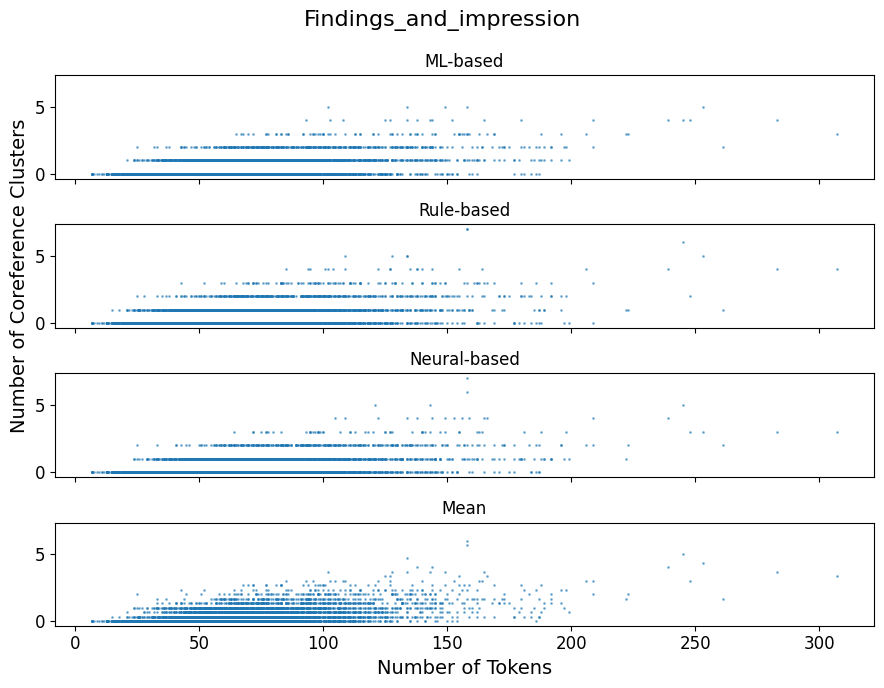

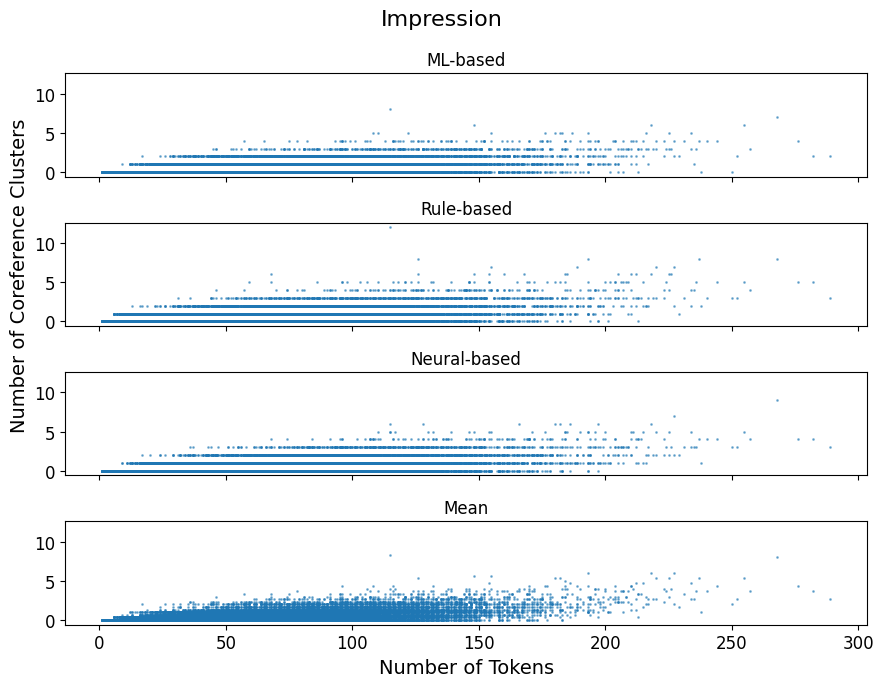

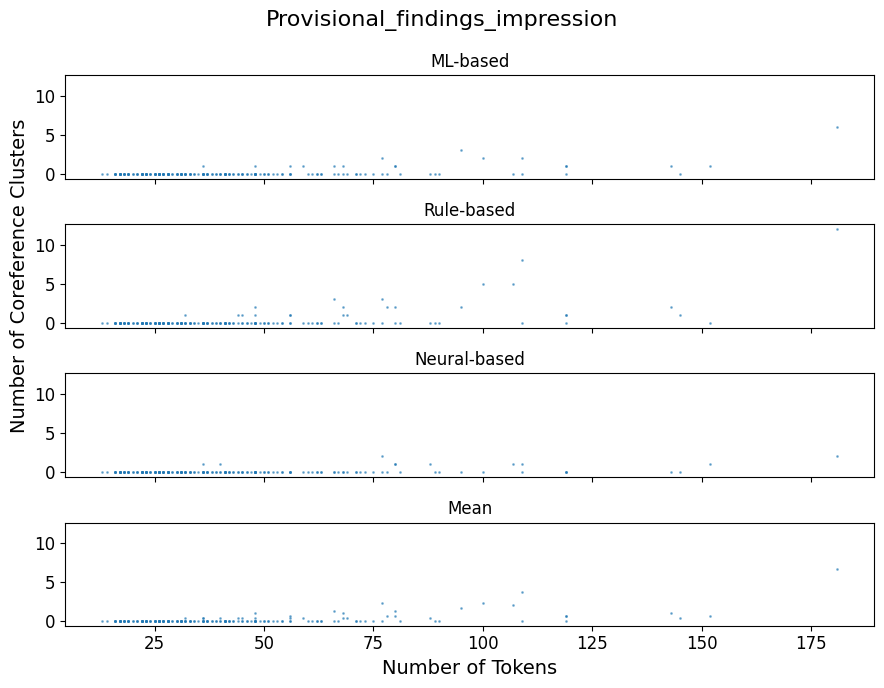

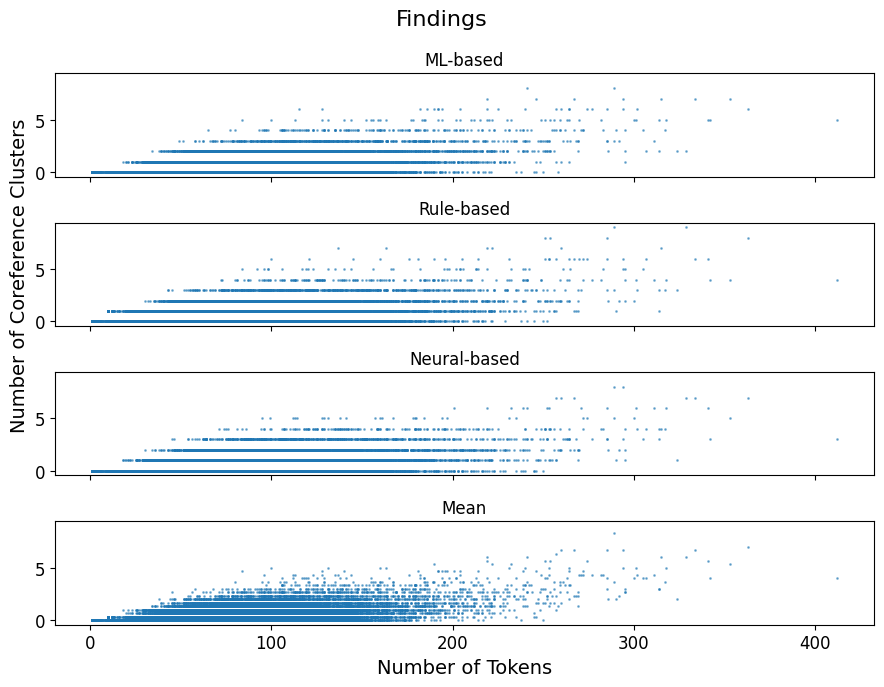

In [21]:
for section_name, scatter_data_list in section_scatter_data_list.items():

    scatter_data_list = sorted(scatter_data_list, key=lambda x: x["tokNum"]) # Sort by token num

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(9,7))
    fig.suptitle(f"{section_name.capitalize()}")
    fig.tight_layout()

    ax1.scatter([data_dict["tokNum"] for data_dict in scatter_data_list], [data_dict["sNum"] for data_dict in scatter_data_list],s=1, alpha=0.5)
    ax2.scatter([data_dict["tokNum"] for data_dict in scatter_data_list], [data_dict["dNum"] for data_dict in scatter_data_list],s=1, alpha=0.5)
    ax3.scatter([data_dict["tokNum"] for data_dict in scatter_data_list], [data_dict["fNum"] for data_dict in scatter_data_list],s=1, alpha=0.5)
    ax4.scatter([data_dict["tokNum"] for data_dict in scatter_data_list], [data_dict["avgNum"] for data_dict in scatter_data_list],s=1, alpha=0.5)

    ax1.set_title("ML-based")
    ax2.set_title("Rule-based")
    ax3.set_title("Neural-based")
    ax4.set_title("Mean")
    ax2.set_ylabel("Number of Coreference Clusters", fontdict={"size":14})
    ax4.set_xlabel("Number of Tokens", fontdict={"size":14})
    fig.tight_layout()
            

### The Bar charts of "number of coreference on average in the scale of token numbers" for each section

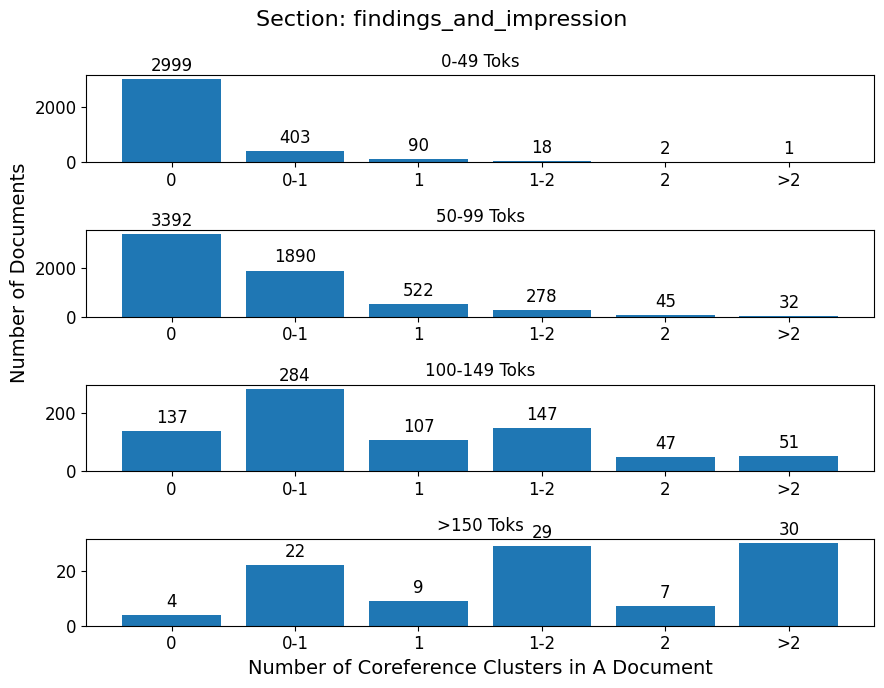

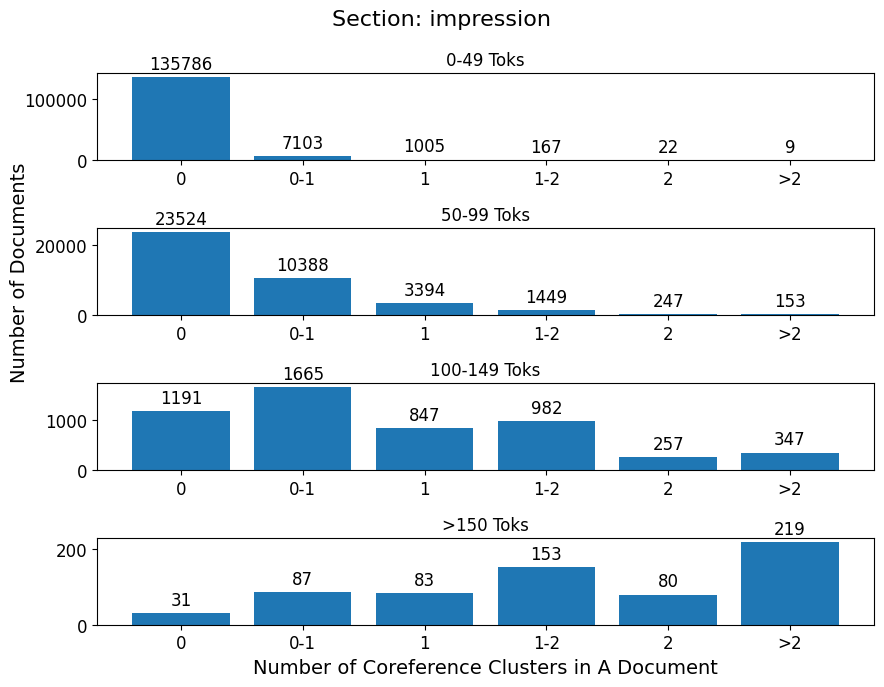

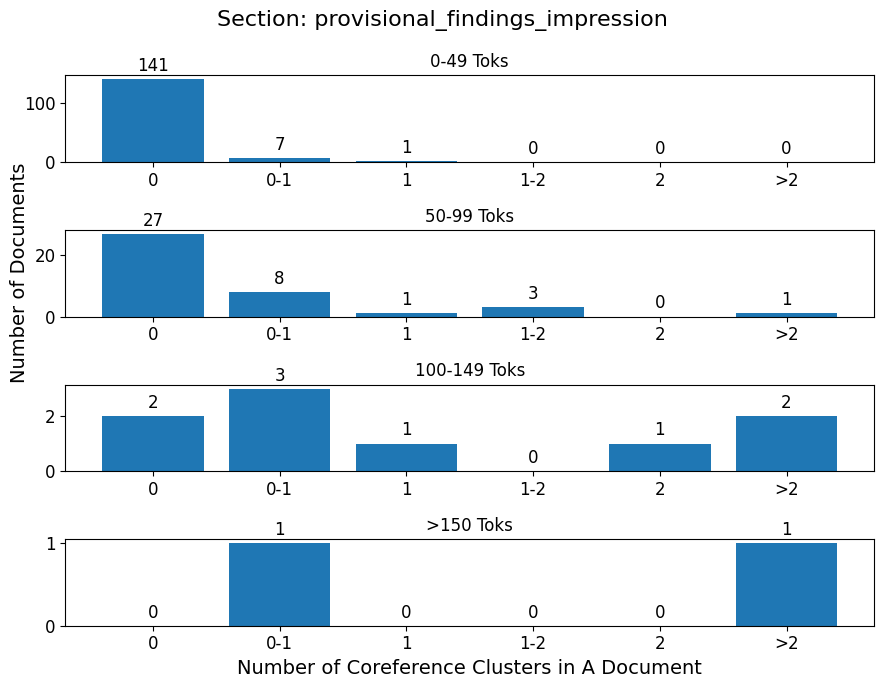

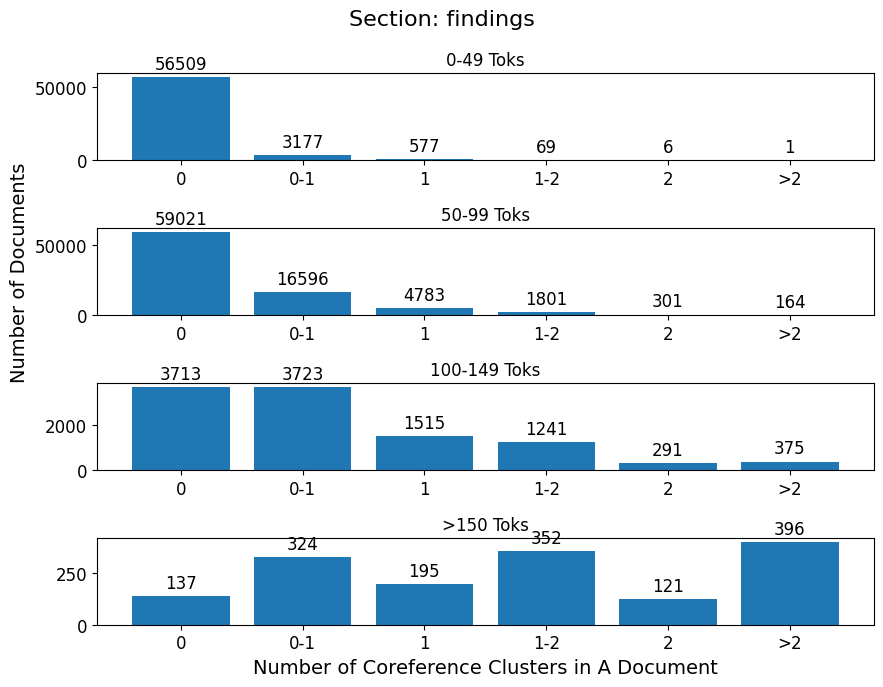

In [19]:
section_tokRange_corefRange_docList_dict:dict[str,dict] = {}
for section_name, doc_numData_dict in section_doc_numData_dict.items():
    section_tokRange_corefRange_docList_dict[section_name] = {
        "0-49 Toks": {
            "0":[], "0-1":[], "1":[], "1-2":[], "2":[], ">2":[]
        },
        "50-99 Toks": {
            "0":[], "0-1":[], "1":[], "1-2":[], "2":[], ">2":[]
        },
        "100-149 Toks": {
            "0":[], "0-1":[], "1":[], "1-2":[], "2":[], ">2":[]
        },
        ">150 Toks": {
            "0":[], "0-1":[], "1":[], "1-2":[], "2":[], ">2":[]
        },
    }
    tokRange_corefRange_docList_dict = section_tokRange_corefRange_docList_dict[section_name]
    for doc_id, numData_dict in doc_numData_dict.items():
        if 0 <= numData_dict["tokNum"] < 50:
            target_dict = tokRange_corefRange_docList_dict["0-49 Toks"]
            if numData_dict["avgNum"] == 0:
                target_dict["0"].append(doc_id)
            elif 0 < numData_dict["avgNum"] < 1:
                target_dict["0-1"].append(doc_id)
            elif numData_dict["avgNum"] == 1:
                target_dict["1"].append(doc_id)
            elif 1 < numData_dict["avgNum"] < 2:
                target_dict["1-2"].append(doc_id)
            elif numData_dict["avgNum"] == 2:
                target_dict["2"].append(doc_id)
            else:
                target_dict[">2"].append(doc_id)
        elif 50 <= numData_dict["tokNum"] < 99:
            target_dict = tokRange_corefRange_docList_dict["50-99 Toks"]
            if numData_dict["avgNum"] == 0:
                target_dict["0"].append(doc_id)
            elif 0 < numData_dict["avgNum"] < 1:
                target_dict["0-1"].append(doc_id)
            elif numData_dict["avgNum"] == 1:
                target_dict["1"].append(doc_id)
            elif 1 < numData_dict["avgNum"] < 2:
                target_dict["1-2"].append(doc_id)
            elif numData_dict["avgNum"] == 2:
                target_dict["2"].append(doc_id)
            else:
                target_dict[">2"].append(doc_id)
        elif 100 <= numData_dict["tokNum"] < 149:
            target_dict = tokRange_corefRange_docList_dict["100-149 Toks"]
            if numData_dict["avgNum"] == 0:
                target_dict["0"].append(doc_id)
            elif 0 < numData_dict["avgNum"] < 1:
                target_dict["0-1"].append(doc_id)
            elif numData_dict["avgNum"] == 1:
                target_dict["1"].append(doc_id)
            elif 1 < numData_dict["avgNum"] < 2:
                target_dict["1-2"].append(doc_id)
            elif numData_dict["avgNum"] == 2:
                target_dict["2"].append(doc_id)
            else:
                target_dict[">2"].append(doc_id)
        elif numData_dict["tokNum"] >= 150:
            target_dict = tokRange_corefRange_docList_dict[">150 Toks"]
            if numData_dict["avgNum"] == 0:
                target_dict["0"].append(doc_id)
            elif 0 < numData_dict["avgNum"] < 1:
                target_dict["0-1"].append(doc_id)
            elif numData_dict["avgNum"] == 1:
                target_dict["1"].append(doc_id)
            elif 1 < numData_dict["avgNum"] < 2:
                target_dict["1-2"].append(doc_id)
            elif numData_dict["avgNum"] == 2:
                target_dict["2"].append(doc_id)
            else:
                target_dict[">2"].append(doc_id)


    fig, axs = plt.subplots(4, 1, figsize=(9,7))
    fig.suptitle(f"Section: {section_name}")

    for ax_id, (tokRangeLabel, corefRangeDict) in enumerate(tokRange_corefRange_docList_dict.items()):
        x = corefRangeDict.keys()
        y = [len(_sid_list) for _sid_list in corefRangeDict.values()]
        bar_container = axs[ax_id].bar(x,y)
        axs[ax_id].set_title(tokRangeLabel)
        axs[ax_id].bar_label(bar_container, padding=3)

    axs[1].set_ylabel("Number of Documents")
    axs[3].set_xlabel("Number of Coreference Clusters in A Document")
    
    fig.tight_layout()


### Confusion Matrix

#### Include 0 coref

Each value shown in a cell is percentage


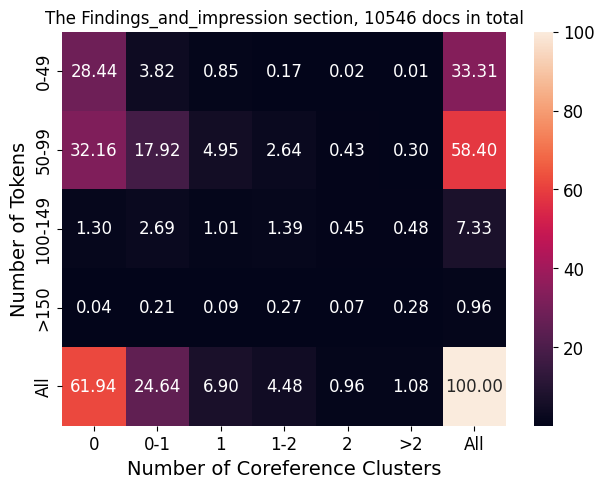

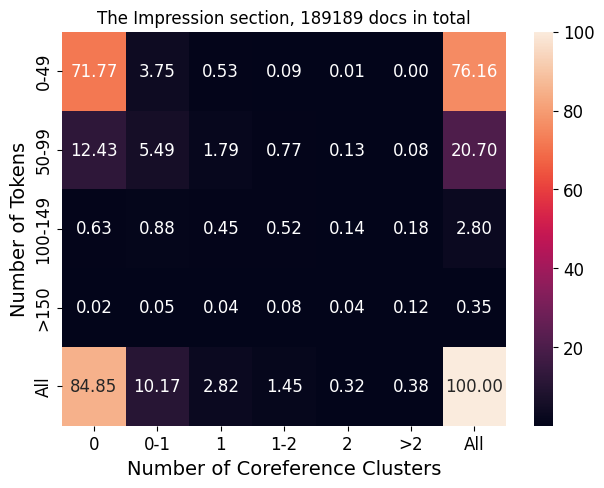

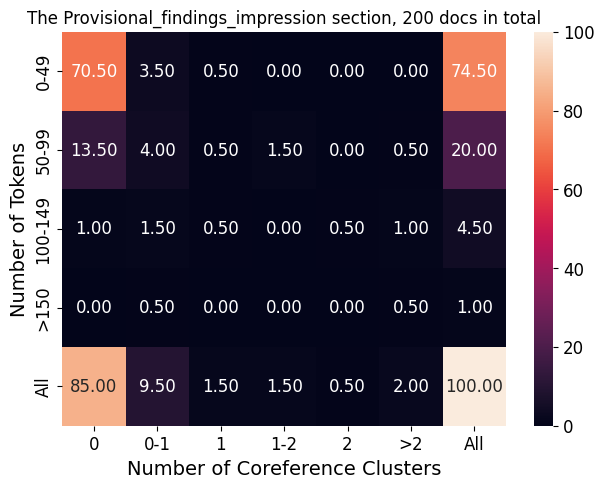

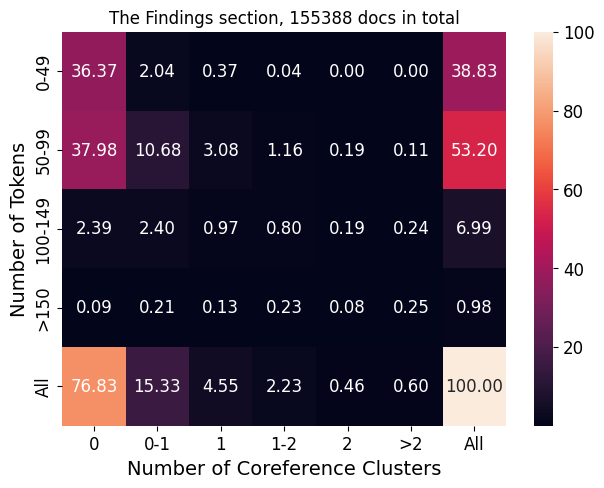

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

for section_name, tokRange_corefRange_docList_dict in section_tokRange_corefRange_docList_dict.items():
    data_list:list[list] = []
    for tokRange, corefRange_docList_dict in tokRange_corefRange_docList_dict.items():
        data_row = []
        data_list.append(data_row)
        for corefRange, docList in corefRange_docList_dict.items():
            data_row.append(len(docList))
    data = np.array(data_list)
    percentages = data/data.sum() * 100

    new_row = []
    for col_idx in range(len(percentages[0])):
        new_row.append(percentages[:,col_idx].sum())
    new_percentages = np.append(percentages, [new_row], 0)

    new_col = []
    for row_idx in range(len(new_percentages)):
        new_col.append([new_percentages[row_idx].sum()])
    new_percentages = np.append(new_percentages, new_col, 1)

    x_labels = ["0", "0-1", "1", "1-2", "2", ">2", "All"]
    y_labels = ["0-49","50-99", "100-149", ">150", "All"]

    plt.figure() #this creates a new figure on which your plot will appear
    plt.title(f"The {section_name.capitalize()} section, {data.sum()} docs in total")
    plt.tight_layout()

    ax = sns.heatmap(new_percentages, xticklabels=x_labels, yticklabels=y_labels, annot=True, fmt='.2f')
    ax.set_xlabel("Number of Coreference Clusters")
    ax.set_ylabel("Number of Tokens")

print("Each value shown in a cell is percentage")

#### Exclude 0 coref

Each value shown in a cell is percentage


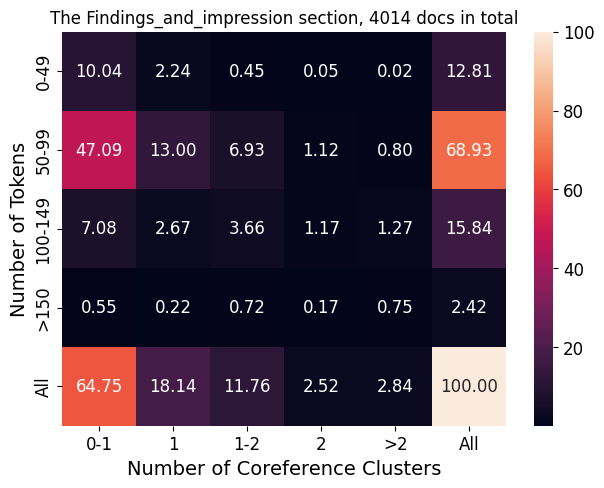

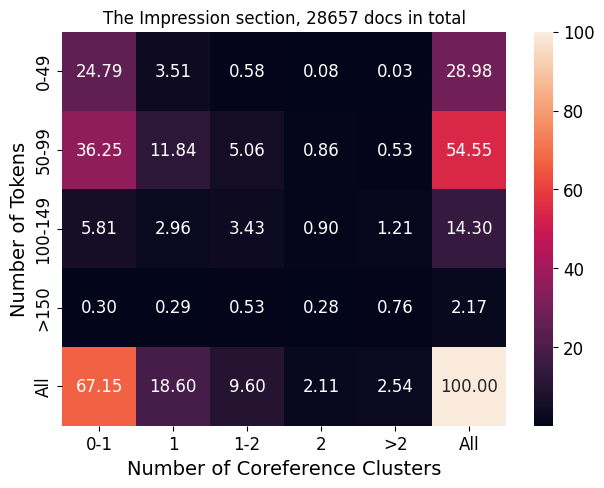

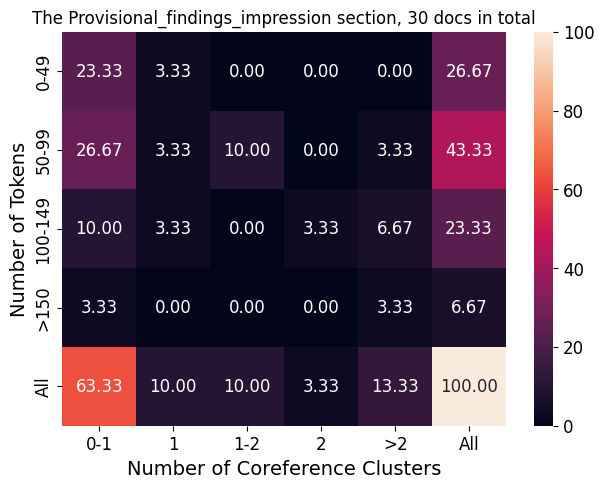

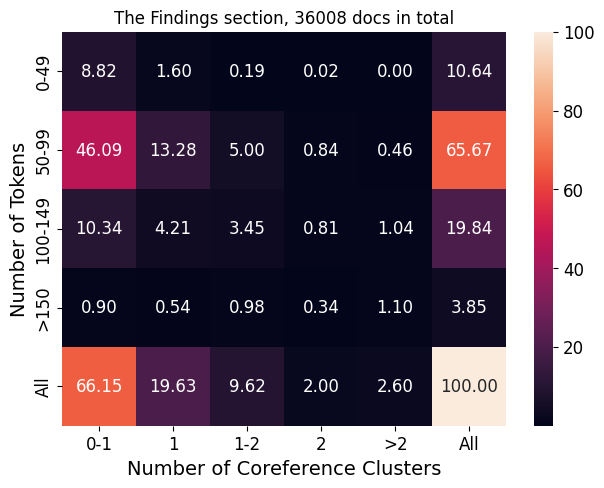

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

for section_name, tokRange_corefRange_docList_dict in section_tokRange_corefRange_docList_dict.items():
    data_list:list[list] = []
    for tokRange, corefRange_docList_dict in tokRange_corefRange_docList_dict.items():
        data_row = []
        data_list.append(data_row)
        for corefRange, docList in corefRange_docList_dict.items():
            if corefRange == "0":
                continue
            data_row.append(len(docList))
    data = np.array(data_list)
    percentages = data/data.sum() * 100

    # add overall statistic
    new_row = []
    for col_idx in range(len(percentages[0])):
        new_row.append(percentages[:,col_idx].sum())
    new_percentages = np.append(percentages, [new_row], 0)

    new_col = []
    for row_idx in range(len(new_percentages)):
        new_col.append([new_percentages[row_idx].sum()])
    new_percentages = np.append(new_percentages, new_col, 1)

    x_labels = ["0-1", "1", "1-2", "2", ">2", "All"]
    y_labels = ["0-49","50-99", "100-149", ">150", "All"]

    plt.figure() #this creates a new figure on which your plot will appear
    plt.title(f"The {section_name.capitalize()} section, {data.sum()} docs in total")
    plt.tight_layout()

    ax = sns.heatmap(new_percentages, xticklabels=x_labels, yticklabels=y_labels, annot=True, fmt='.2f')
    ax.set_xlabel("Number of Coreference Clusters")
    ax.set_ylabel("Number of Tokens")

print("Each value shown in a cell is percentage")

In [9]:
print(data)

new_row = []
for col_idx in range(len(data[0])):
    new_row.append(data[:,col_idx].sum())

new_data = np.append(data, [new_row], 0)


new_col = []
for row_idx in range(len(new_data)):
    new_col.append([new_data[row_idx].sum()])

new_data = np.append(new_data, new_col, 1)

print(new_data)


[[ 3177   577    69     6     1]
 [16596  4783  1801   301   164]
 [ 3723  1515  1241   291   375]
 [  324   195   352   121   396]]
[[ 3177   577    69     6     1  3830]
 [16596  4783  1801   301   164 23645]
 [ 3723  1515  1241   291   375  7145]
 [  324   195   352   121   396  1388]
 [23820  7070  3463   719   936 36008]]


## Step 1: sampling without .ann for round 1

### Example

In [21]:
doc_id = section_tokRange_corefRange_docList_dict["findings"]["100-149 Toks"]["1"][0]
section_name = "findings"
print("section_name, doc_id:",section_name, doc_id)

df_scoref = pd.read_csv(os.path.join(scoref_dir,section_name,f"{doc_id}.csv"), index_col=0, na_filter=False)
df_dcoref = pd.read_csv(os.path.join(dcoref_dir,section_name,f"{doc_id}.csv"), index_col=0, na_filter=False)
df_fcoref = pd.read_csv(os.path.join(fcoref_dir,section_name,f"{doc_id}.csv"), index_col=0, na_filter=False)


_, scoref_group_num = resolve_mention_and_group_num(df_scoref, "[co][ml]coref_group_conll")
_, dcoref_group_num = resolve_mention_and_group_num(df_dcoref, "[co][rb]coref_group_conll")
_, fcoref_group_num = resolve_mention_and_group_num(df_fcoref, "[fj]coref_group_conll")

print("scoref_group_num, dcoref_group_num, fcoref_group_num:", scoref_group_num, dcoref_group_num, fcoref_group_num)
print(section_list[0][1][sid_list.index(doc_id)])

section_name, doc_id: findings s54350689
scoref_group_num, dcoref_group_num, fcoref_group_num: 1 0 2
___.
PA and lateral views of the chest are compared to both prior chest x-ray from ___ and CT chest from ___. 
 Compared to prior exam, there has been no significant interval change in the widespread parenchymal opacities throughout the lung fields which are associated with overall volume loss.  There is no definite new region of consolidation nor pleural effusion.  Cardiac silhouette appears enlarged but could be accentuated due to lower lung volumes.  This is unchanged from prior. Osseous and soft tissue structures are unremarkable.


### Sampling for first 100 annotation docs for round 1 annotation procedure

Criteria: we sample based on the token numbers and the number of coreference groups per doc.

To do this, we need to run all the previous scripts in advance

In [22]:
import random
random.seed(SEED_NUM)

sampling_num_dict = {
    "findings": [
        [2,3,2,1,1,1],
        [7,5,5,4,1,1],
        [3,2,2,2,1,1],
        [1,1,1,1,1,1]
    ],
        "impression": [
        [4,3,2,1,1,1],
        [6,5,5,4,1,1],
        [2,2,2,2,1,1],
        [1,1,1,1,1,1]
    ]
}
output_section_doc_dict = {}
for section_name, tokRange_corefRange_docList_dict in section_tokRange_corefRange_docList_dict.items():
    if section_name not in sampling_num_dict:
        continue
    output_section_doc_dict[section_name] = []
    for x_idx,(tokRange, corefRange_docList_dict) in enumerate(tokRange_corefRange_docList_dict.items()):
        for y_idx, (corefRange, docList) in enumerate(corefRange_docList_dict.items()):
            docList = sorted(docList)
            required_num = sampling_num_dict[section_name][x_idx][y_idx]
            sampled_doc = [docList[random.randint(0,len(docList)-1)] for _ in range(required_num)]
            output_section_doc_dict[section_name].extend(sampled_doc)
            print(section_name, tokRange, corefRange, sampled_doc)

impression 0-49toks 0coref ['s52181400', 's50495534', 's55413865', 's54830797']
impression 0-49toks 0-1coref ['s54088920', 's52560967', 's51912229']
impression 0-49toks 1coref ['s59561237', 's51384527']
impression 0-49toks 1-2coref ['s57721486']
impression 0-49toks 2coref ['s50870177']
impression 0-49toks >2coref ['s50857443']
impression 50-99toks 0coref ['s51485705', 's53490136', 's53712847', 's58053419', 's59588224', 's50420639']
impression 50-99toks 0-1coref ['s57456995', 's52639006', 's59520223', 's58642308', 's59317535']
impression 50-99toks 1coref ['s56243300', 's54785672', 's52553303', 's55122346', 's56670734']
impression 50-99toks 1-2coref ['s52812639', 's58173343', 's58795811', 's50057221']
impression 50-99toks 2coref ['s52391473']
impression 50-99toks >2coref ['s56799694']
impression 100-149toks 0coref ['s54745658', 's53752672']
impression 100-149toks 0-1coref ['s53383593', 's52015567']
impression 100-149toks 1coref ['s52484542', 's59586953']
impression 100-149toks 1-2coref [

In [23]:
from tqdm import tqdm
from common_utils.common_utils import check_and_remove_dirs

round1_base_dir = "../../output/mimic_cxr/brat_annotation_original/round1"

check_and_remove_dirs(round1_base_dir, True)
for section_name, _doc_list in output_section_doc_dict.items():
    output_dir = os.path.join(round1_base_dir,section_name)
    check_and_create_dirs(output_dir)
    input_dir = os.path.join("../../output/mimic_cxr/nlp_ensemble/spacy",section_name)
    for doc_id in tqdm(_doc_list):
        df_spacy = pd.read_csv(os.path.join(input_dir, f"{doc_id}.csv"), index_col=0, na_filter=False)
        df_sentence = df_spacy.groupby(['[sp]sentence_group'])['[sp]token'].apply(' '.join).reset_index()
        sentences = [str(_series.get("[sp]token")).strip() for _, _series in df_sentence.iterrows()]
        with open(os.path.join(output_dir, f"{doc_id}.txt"), "w", encoding="UTF-8") as f:
            f.write("\n".join(sentences))

100%|██████████| 50/50 [00:00<00:00, 512.65it/s]


## Prepare 2

In [3]:
class AnnMentionClass:
    def __init__(self) -> None:
        self.id = ""
        self.type = "Mention"
        self.start_index = ""
        self.end_index = ""
        self.token_str_list = []
        self.token_str = ""
    
    def get_ann_str(self) -> str:
        return f"{self.id}\t{self.type} {self.start_index} {self.end_index}\t{' '.join(self.token_str_list)}\n"

    def set_end_index(self, value, text):
        self.end_index = value
        self.token_str = text[self.start_index:self.end_index]

    def __repr__(self) -> str:
        return self.get_ann_str()
    def __str__(self) -> str:
        return self.get_ann_str()

class AnnCoreferenceClass:
    def __init__(self) -> None:
        self.id = ""
        self.type = "Coreference"
        self.anaphora = ""
        self.antecedent = ""
    
    def get_ann_str(self) -> str:
        return f"{self.id}\t{self.type} Anaphora:{self.anaphora} Antecedent:{self.antecedent}\t\n"

    def __repr__(self) -> str:
        return self.get_ann_str()
    def __str__(self) -> str:
        return self.get_ann_str()


def get_AnnMentionClass_notClosed(ann_ment_list: list[AnnMentionClass]) -> AnnMentionClass:
    for annMent in ann_ment_list:
        if annMent.end_index == "":
            return annMent
    return None


Get data distribution

In [4]:
from collections import defaultdict, Counter

from common_utils.coref_utils import get_file_name_prefix


coref_group_conll_colName = "[fj]coref_group_conll"
input_base_dir = "../../output/mimic_cxr/nlp_ensemble/fast_coref_301"

def batch_processing2(file_name, input_file_path):
    START_EVENT.wait()
    doc_id = get_file_name_prefix(input_file_path, ".csv")
    df = pd.read_csv(input_file_path, index_col=0, na_filter=False)
    _, coref_group_num = resolve_mention_and_group_num(df, coref_group_conll_colName, omit_singleton=True)
    return doc_id, coref_group_num

section_doc_coref_counter = defaultdict(Counter)
all_section_corefGroupNum_docId_dict = {}
for section_name in ["findings", "impression"]:
    with ProcessPoolExecutor(max_workers=15) as executor:
        all_task = []
        input_dir = os.path.join(input_base_dir, section_name)
        for file_name in tqdm(FILE_CHECKER.filter(os.listdir(input_dir))):
            input_file_path = os.path.join(input_dir, file_name)
            all_task.append(executor.submit(batch_processing2, file_name, input_file_path))

        # Notify tasks to start
        START_EVENT.set()

        corefGroupNum_docId_dict = defaultdict(list)
        if all_task:
            for future in tqdm(as_completed(all_task), total=len(all_task)):
                doc_id, coref_group_num = future.result()
                section_doc_coref_counter[section_name].update([coref_group_num])
                corefGroupNum_docId_dict[coref_group_num].append(doc_id)
                
        all_section_corefGroupNum_docId_dict[section_name] = corefGroupNum_docId_dict
        executor.shutdown(wait=True, cancel_futures=False)
        START_EVENT.clear()

100%|██████████| 189465/189465 [00:42<00:00, 4429.79it/s]


In [5]:
def get_gt_doc_list(gt_source_list):
    """ Get docs that were used for previous round """
    gt_section_docId_dict:dict[str,list] = {}
    for section_name in ["findings","impression"]:
        for source_dir in gt_source_list:
            gt_all_dir = os.path.join(source_dir, section_name)
            gt_section_docId_dict.setdefault(section_name,[]).extend([i.rstrip(".txt") for i in FILE_CHECKER.filter(os.listdir(gt_all_dir)) if i.endswith(".txt")])
        
    # The coref distribution (majority_voting version) of the annotated gt files.
    gt_section_corefGroupNum_docId_dict = {}
    for section_name in ["findings","impression"]:
        gt_section_corefGroupNum_docId_dict[section_name] = {}
        for coref_num, doc_id_list in all_section_corefGroupNum_docId_dict[section_name].items():
            gt_section_corefGroupNum_docId_dict[section_name][coref_num] = []
            for doc_id in gt_section_docId_dict[section_name]:
                if doc_id in doc_id_list:
                    gt_section_corefGroupNum_docId_dict[section_name][coref_num].append(doc_id)
    return gt_section_corefGroupNum_docId_dict

Check data distribution

In [7]:
# A list of gt docs that were used for previous round and thus should be excluded
gt_brat_source_list = [
    "../../output/mimic_cxr/brat_annotation_original/round3",
    "../../output/mimic_cxr/brat_annotation_original/round4_100_1",
    "../../output/mimic_cxr/brat_annotation_original/round4_100_2",
    # "../../output/mimic_cxr/coref_voting/majority_voting_sampling1"
]
gt_section_corefGroupNum_docId_dict = get_gt_doc_list(gt_brat_source_list)

print("The data distribution of all docs:")
for section_name, corefGroupNum_docId_dict in all_section_corefGroupNum_docId_dict.items():
    print(section_name, [(coref_num, len(doc_id_list)) for coref_num, doc_id_list in sorted(corefGroupNum_docId_dict.items(), key=lambda x: x[0])])

print("\nThe data distribution of test docs (docs that had been selected for annotation):")
for section_name, corefGroupNum_docId_dict in gt_section_corefGroupNum_docId_dict.items():
    print(section_name, [(coref_num, len(doc_id_list)) for coref_num, doc_id_list in sorted(corefGroupNum_docId_dict.items(), key=lambda x: x[0])])

print("\nThe data distribution of all docs excluding test docs")
for section_name, corefGroupNum_docId_dict in all_section_corefGroupNum_docId_dict.items():
    print(section_name, [(coref_num, len(doc_id_list)-len(gt_section_corefGroupNum_docId_dict[section_name][coref_num])) for coref_num, doc_id_list in sorted(corefGroupNum_docId_dict.items(), key=lambda x: x[0])])

The data distribution of all docs:
findings [(0, 136639), (1, 15956), (2, 2624), (3, 597), (4, 145), (5, 37), (6, 12), (7, 1)]
impression [(0, 173932), (1, 12634), (2, 2197), (3, 561), (4, 110), (5, 22), (6, 6), (7, 2), (8, 1)]

The data distribution of test docs (docs that had been selected for annotation):
findings [(0, 0), (1, 60), (2, 60), (3, 21), (4, 6), (5, 3), (6, 0), (7, 0)]
impression [(0, 0), (1, 60), (2, 60), (3, 21), (4, 6), (5, 3), (6, 0), (7, 0), (8, 0)]

The data distribution of all docs excluding test docs
findings [(0, 136639), (1, 15896), (2, 2564), (3, 576), (4, 139), (5, 34), (6, 12), (7, 1)]
impression [(0, 173932), (1, 12574), (2, 2137), (3, 540), (4, 104), (5, 19), (6, 6), (7, 2), (8, 1)]


## Step 2: sampling manual annotation data (without .ann files) for round 2

Design the sampling distribution for next round

In [24]:
gt_brat_source_list = [
    "../../output/mimic_cxr/brat_annotation_original/round1",
]
gt_section_corefGroupNum_docId_dict = get_gt_doc_list(gt_brat_source_list)

section_corefGroupNum_sampleDocNum_dict = {
    "findings": {1: 20, 2: 20, 3: 7, 4: 2, 5: 1},
    "impression": {1: 20, 2: 20, 3: 7, 4: 2, 5: 1}
}

### Generate annotation data without .ann files

The input data is csv format, could use fast_coref_301 output or ensemble (majority_voting) output 

In [25]:
from common_utils.coref_utils import shuffle_list

brat_output_dir = os.path.join("../../output/mimic_cxr/brat_annotation_original/round2")
check_and_remove_dirs(brat_output_dir,True)
# Choose to use majority_voting or fast_coref_301, and change corresponding column name
csv_source_base_dir = os.path.join("../../output/mimic_cxr/nlp_ensemble/fast_coref_301")
token_colName = "[fj]token_from_spacy" # mv: [sp]token, jf: [fj]token_from_spacy
sentence_group_colName = "[fj]sentence_group" # mv: [sp]sentence_group, jf: [fj]sentence_group
coref_group_conll_colName = "[fj]coref_group_conll" # mv: [mv]coref_group_conll, jf: [fj]coref_group_conll

for section_name, corefGroupNum_sampleDocNum_dict in section_corefGroupNum_sampleDocNum_dict.items():
    # sample_num_str = "{1: 544, 2: 544, 3: 295, 4: 83, 5: 25, 6: 6, 7: 2, 8: 1}"
    input_dir = os.path.join(csv_source_base_dir, section_name)
    for groupNum, sampleDocNum in corefGroupNum_sampleDocNum_dict.items():
        # Get the acutal doc ids. Remove the doc_ids that used in testset. Then shuffle.
        docId_all_list = all_section_corefGroupNum_docId_dict[section_name][groupNum]
        docId_exclude_list = gt_section_corefGroupNum_docId_dict[section_name][groupNum]
        docId_list_excluded = [x for x in docId_all_list if x not in docId_exclude_list]
        docId_list_shuffle = shuffle_list(docId_list_excluded, SEED_NUM)
        
        for doc_id in docId_list_shuffle[0:sampleDocNum]:
            df_spacy = pd.read_csv(os.path.join(input_dir, f"{doc_id}.csv"), index_col=0, na_filter=False)
            df_sentence = df_spacy.groupby([sentence_group_colName])[token_colName].apply('#@#'.join).reset_index()
            df_coref = df_spacy.groupby([sentence_group_colName])[coref_group_conll_colName].apply(list).reset_index()

            sentences = [str(_series.get(token_colName)).replace("#@#"," ").strip() for _, _series in df_sentence.iterrows()]
            text = "\n".join(sentences)
            
            # .txt files
            output_dir = os.path.join(brat_output_dir, section_name)
            check_and_create_dirs(output_dir)
            with open(os.path.join(output_dir, f"{doc_id}.txt"), "w", encoding="UTF-8") as f:
                f.write(text)

## Step 3: sampling semi-auto annotation data (with .ann files) for round 3

Design the sampling distribution for next round

In [10]:
gt_brat_source_list = [
    "../../output/mimic_cxr/brat_annotation_original/round1",
    "../../output/mimic_cxr/brat_annotation_original/round2",
    "../../output/mimic_cxr/brat_annotation_original/round3",
    "../../output/mimic_cxr/brat_annotation_original/round4_100_1",
    "../../output/mimic_cxr/brat_annotation_original/round4_100_2",
    "../../output/mimic_cxr/brat_annotation_original/round4_100_3"
]
gt_section_corefGroupNum_docId_dict = get_gt_doc_list(gt_brat_source_list)

section_corefGroupNum_sampleDocNum_dict = {
    "findings": {1: 20, 2: 20, 3: 7, 4: 2, 5: 1},
    "impression": {1: 20, 2: 20, 3: 7, 4: 2, 5: 1}
}

### Perform majority voting (do only if majority_voting is required)

Turn off the comment when required the majority voting results

In [ ]:
# from common_utils.coref_utils import shuffle_list
# import coref_voting
# from coref_voting import DocClass, MentionClass, compute_voting_result, get_output_df
# from hydra import compose, initialize
# from omegaconf import OmegaConf

# config = None
# with initialize(version_base=None, config_path="../config", job_name="create_ann"):
#         config = compose(config_name="coreference_resolution", overrides=["+coreference_resolution/coref_voting@_global_=mimic_cxr"])

# mv_output_base_dir = os.path.join("../../output/mimic_cxr/coref_voting/majority_voting_sampling2")

# def batch_processing3(config, spacy_file_path, section_name, file_name):
#     """ Voting on one document """
#     START_EVENT.wait()

#     # Read spacy output as alignment base
#     df_spacy = pd.read_csv(spacy_file_path, index_col=0, na_filter=False)
#     # Some of the i2b2 raw files are utf-8 start with DOM, but we didn't remove the DOM character, thus we fix it here.
#     df_spacy.iloc[0] = df_spacy.iloc[0].apply(lambda x: x.replace("\ufeff", "").replace("\xef\xbb\xbf", "") if isinstance(x, str) else x)

#     docObj: DocClass = coref_voting.resolve_voting_info(config, df_spacy, section_name, file_name)
#     valid_mention_group: list[set[MentionClass]] = compute_voting_result(config, docObj)
#     df_out = get_output_df(config, df_spacy, valid_mention_group, docObj)

#     output_dir = os.path.join(mv_output_base_dir, section_name)
#     check_and_create_dirs(output_dir)
#     output_file_path = os.path.join(output_dir, file_name)

#     df_out.to_csv(output_file_path)

#     return f"{file_name} done."

# for section_name, corefGroupNum_sampleDocNum_dict in section_corefGroupNum_sampleDocNum_dict.items():
#     # sample_num_str = "{1: 544, 2: 544, 3: 295, 4: 83, 5: 25, 6: 6, 7: 2, 8: 1}"
#     with ProcessPoolExecutor(max_workers=config.thread.workers) as executor:
#         all_task = []
#         for groupNum, sampleDocNum in corefGroupNum_sampleDocNum_dict.items():
#             # Get the acutal doc ids. Remove the doc_ids that used in testset. Then shuffle.
#             docId_all_list = all_section_corefGroupNum_docId_dict[section_name][groupNum]
#             docId_exclude_list = gt_section_corefGroupNum_docId_dict[section_name][groupNum]
#             docId_list_excluded = [x for x in docId_all_list if x not in docId_exclude_list]
#             docId_list_shuffle = shuffle_list(docId_list_excluded, 42)
            
#             for doc_id in docId_list_shuffle[0:sampleDocNum]:
#                 file_name = doc_id + ".csv"
#                 spacy_out_dir = os.path.join(config.input.source.baseline_model.dir, section_name)
#                 spacy_file_path = os.path.join(spacy_out_dir, file_name)
#                 all_task.append(executor.submit(batch_processing3, config, spacy_file_path, section_name, file_name))
        
#          # Notify tasks to start
#         START_EVENT.set()

#         if all_task:
#             for future in tqdm(as_completed(all_task), total=len(all_task)):
#                 msg = future.result()

#         executor.shutdown(wait=True, cancel_futures=False)
#         START_EVENT.clear()

### Generate annotation data with .ann files

The input data is csv format, could use fast_coref_301 output or ensemble (majority_voting) output 

Run the previous script if ensemble (majority_voting) output is required

In [11]:
from common_utils.coref_utils import shuffle_list

brat_output_dir = os.path.join("../../output/mimic_cxr/brat_annotation_original/round4_100_4")
check_and_remove_dirs(brat_output_dir,True)

# Choose to use majority_voting or fast_coref_301, and change corresponding column name
csv_source_base_dir = os.path.join("../../output/mimic_cxr/nlp_ensemble/fast_coref_301")
token_colName = "[fj]token_from_spacy" # mv: [sp]token, jf: [fj]token_from_spacy
sentence_group_colName = "[fj]sentence_group" # mv: [sp]sentence_group, jf: [fj]sentence_group
coref_group_conll_colName = "[fj]coref_group_conll" # mv: [mv]coref_group_conll, jf: [fj]coref_group_conll

for section_name, corefGroupNum_sampleDocNum_dict in section_corefGroupNum_sampleDocNum_dict.items():
    # sample_num_str = "{1: 544, 2: 544, 3: 295, 4: 83, 5: 25, 6: 6, 7: 2, 8: 1}"
    input_dir = os.path.join(csv_source_base_dir, section_name)
    for groupNum, sampleDocNum in corefGroupNum_sampleDocNum_dict.items():
        # Get the acutal doc ids. Remove the doc_ids that used in testset. Then shuffle.
        docId_all_list = all_section_corefGroupNum_docId_dict[section_name][groupNum]
        docId_exclude_list = gt_section_corefGroupNum_docId_dict[section_name][groupNum]
        docId_list_excluded = [x for x in docId_all_list if x not in docId_exclude_list]
        docId_list_shuffle = shuffle_list(docId_list_excluded, SEED_NUM)
        
        for doc_id in docId_list_shuffle[0:sampleDocNum]:
            df_spacy = pd.read_csv(os.path.join(input_dir, f"{doc_id}.csv"), index_col=0, na_filter=False)
            df_sentence = df_spacy.groupby([sentence_group_colName])[token_colName].apply('#@#'.join).reset_index()
            df_coref = df_spacy.groupby([sentence_group_colName])[coref_group_conll_colName].apply(list).reset_index()

            sentences = [str(_series.get(token_colName)).replace("#@#"," ").strip() for _, _series in df_sentence.iterrows()]
            text = "\n".join(sentences)
            
            # .txt files
            output_dir = os.path.join(brat_output_dir, section_name)
            check_and_create_dirs(output_dir)
            with open(os.path.join(output_dir, f"{doc_id}.txt"), "w", encoding="UTF-8") as f:
                f.write(text)

            # .ann files
            with open(os.path.join(output_dir, f"{doc_id}.ann"), "w", encoding="UTF-8") as f:
                mention_id = 0
                groupNum_mentions_dict:dict[int, list[AnnMentionClass]] = defaultdict(list)
                offset = 0
                for _idx, _series in df_sentence.iterrows():
                    token_list = _series.get(token_colName).strip().strip("#@#").split('#@#') # Remove the last whitespace
                    conll_labelStr_list = df_coref.loc[_idx,].get(coref_group_conll_colName) # The corresponding conll label of last whitespace are reamined so far
                    
                    for tok_id, tok in enumerate(token_list): # The corresponding conll label of last whitespace will be ignored 
                        conll_labelListStr = conll_labelStr_list[tok_id]
                        if conll_labelListStr not in [-1, "-1", np.nan]:
                            for conll_label in ast.literal_eval(conll_labelListStr):
                                if "(" in conll_label:
                                    ann_mention_class = AnnMentionClass()
                                    ann_mention_class.id = f"T{mention_id}"
                                    ann_mention_class.start_index = offset
                                    mention_id+=1
                                    if ")" in conll_label:
                                        ann_mention_class.set_end_index(offset + len(tok), "\n".join(sentences))
                                        coref_id = int(conll_label.replace("(","").replace(")",""))
                                    else:
                                        coref_id = int(conll_label.replace("(",""))
                                    groupNum_mentions_dict[coref_id].append(ann_mention_class)
                                elif "(" not in conll_label and ")" in conll_label:
                                    coref_id = int(conll_label.replace(")",""))
                                    ann_mention_class = get_AnnMentionClass_notClosed(groupNum_mentions_dict[coref_id])
                                    ann_mention_class.set_end_index(offset + len(tok), "\n".join(sentences))

                        offset += len(tok) + 1
                    offset = sum([len(sent) for sent in sentences[0:_idx+1]]) + _idx + 1 # The offset of the sentence start.

                pair_id = 0
                for _, ann_mention_list in groupNum_mentions_dict.items():
                    for _id, ann_mention_class in enumerate(ann_mention_list):
                        f.write(ann_mention_class.get_ann_str())

                    for _id, ann_mention_class in enumerate(ann_mention_list):
                        if _id == 0:
                            continue
                        ann_coref_class = AnnCoreferenceClass()
                        ann_coref_class.id = f"R{pair_id}"
                        ann_coref_class.anaphora = ann_mention_list[_id-1].id
                        ann_coref_class.antecedent = ann_mention_list[_id].id

                        f.write(ann_coref_class.get_ann_str())
                        pair_id += 1

# Re-create round_x data for semiauto annotation

In [16]:
target_docs_path = os.path.join("../../output/mimic_cxr/brat_annotation_original/round2")
section_docId_dict = defaultdict(list)
section_docId_dict["findings"] = [doc_id.strip(".txt") for doc_id in os.listdir(os.path.join(target_docs_path, "findings")) if doc_id.endswith(".txt")]
section_docId_dict["impression"] = [doc_id.strip(".txt") for doc_id in os.listdir(os.path.join(target_docs_path, "impression")) if doc_id.endswith(".txt")]

In [17]:
from common_utils.coref_utils import shuffle_list

brat_output_dir = os.path.join("../../output/mimic_cxr/brat_annotation_original/round2_semiauto")
check_and_remove_dirs(brat_output_dir,True)

# Choose to use majority_voting or fast_coref_301, and change corresponding column name
csv_source_base_dir = os.path.join("../../output/mimic_cxr/nlp_ensemble/fast_coref_301")
token_colName = "[fj]token_from_spacy" # mv: [sp]token, jf: [fj]token_from_spacy
sentence_group_colName = "[fj]sentence_group" # mv: [sp]sentence_group, jf: [fj]sentence_group
coref_group_conll_colName = "[fj]coref_group_conll" # mv: [mv]coref_group_conll, jf: [fj]coref_group_conll

for section_name, docId_list in section_docId_dict.items():
    
    input_dir = os.path.join(csv_source_base_dir, section_name)
    for doc_id in docId_list:
        
        df_spacy = pd.read_csv(os.path.join(input_dir, f"{doc_id}.csv"), index_col=0, na_filter=False)
        df_sentence = df_spacy.groupby([sentence_group_colName])[token_colName].apply('#@#'.join).reset_index()
        df_coref = df_spacy.groupby([sentence_group_colName])[coref_group_conll_colName].apply(list).reset_index()

        sentences = [str(_series.get(token_colName)).replace("#@#"," ").strip() for _, _series in df_sentence.iterrows()]
        text = "\n".join(sentences)
        
        # .txt files
        output_dir = os.path.join(brat_output_dir, section_name)
        check_and_create_dirs(output_dir)
        with open(os.path.join(output_dir, f"{doc_id}.txt"), "w", encoding="UTF-8") as f:
            f.write(text)

        # .ann files
        with open(os.path.join(output_dir, f"{doc_id}.ann"), "w", encoding="UTF-8") as f:
            mention_id = 0
            groupNum_mentions_dict:dict[int, list[AnnMentionClass]] = defaultdict(list)
            offset = 0
            for _idx, _series in df_sentence.iterrows():
                token_list = _series.get(token_colName).strip().strip("#@#").split('#@#') # Remove the last whitespace
                conll_labelStr_list = df_coref.loc[_idx,].get(coref_group_conll_colName) # The corresponding conll label of last whitespace are reamined so far
                
                for tok_id, tok in enumerate(token_list): # The corresponding conll label of last whitespace will be ignored 
                    conll_labelListStr = conll_labelStr_list[tok_id]
                    if conll_labelListStr not in [-1, "-1", np.nan]:
                        for conll_label in ast.literal_eval(conll_labelListStr):
                            if "(" in conll_label:
                                ann_mention_class = AnnMentionClass()
                                ann_mention_class.id = f"T{mention_id}"
                                ann_mention_class.start_index = offset
                                mention_id+=1
                                if ")" in conll_label:
                                    ann_mention_class.set_end_index(offset + len(tok), "\n".join(sentences))
                                    coref_id = int(conll_label.replace("(","").replace(")",""))
                                else:
                                    coref_id = int(conll_label.replace("(",""))
                                groupNum_mentions_dict[coref_id].append(ann_mention_class)
                            elif "(" not in conll_label and ")" in conll_label:
                                coref_id = int(conll_label.replace(")",""))
                                ann_mention_class = get_AnnMentionClass_notClosed(groupNum_mentions_dict[coref_id])
                                ann_mention_class.set_end_index(offset + len(tok), "\n".join(sentences))

                    offset += len(tok) + 1
                offset = sum([len(sent) for sent in sentences[0:_idx+1]]) + _idx + 1 # The offset of the sentence start.

            pair_id = 0
            for _, ann_mention_list in groupNum_mentions_dict.items():
                for _id, ann_mention_class in enumerate(ann_mention_list):
                    f.write(ann_mention_class.get_ann_str())

                for _id, ann_mention_class in enumerate(ann_mention_list):
                    if _id == 0:
                        continue
                    ann_coref_class = AnnCoreferenceClass()
                    ann_coref_class.id = f"R{pair_id}"
                    ann_coref_class.anaphora = ann_mention_list[_id-1].id
                    ann_coref_class.antecedent = ann_mention_list[_id].id

                    f.write(ann_coref_class.get_ann_str())
                    pair_id += 1